In [14]:
import os
from joblib import Parallel, delayed

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.CPQAOA import CP_QAOA
from src.QAOA import QAOA
from src.Grid import Grid
from src.Tools import portfolio_metrics, min_cost_partition, get_qubo, normalized_cost, qubo_limits, check_qubo

# INITIAL TEST RUNS:

In [15]:
# Number of Qubits 
N=9
# Number of excitations
k=4
# RNG seed for reproducibility
seed=1
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Nr. of layer repetitions
layers=3
# Maximal number of iterations for classical solver
max_iter=1000

# Using grid Nearest neighbors
w_grid = True
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = False
# Distributing the 'k' excitations according to some strategy (other than just k first)
w_strategy = True
# Using extra z-phase term
w_z_phase = False



In [16]:
# Generating grid
if w_grid:
    my_grid = Grid(Rows=3, Cols=3)
    print(f' Qubit indices in grid: \n', my_grid.get_grid_indexing())
    print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_grid.get_NN_indices())
    init_strat = np.array([[0,1,0],
                           [1,0,1],
                           [0,1,0]])
    my_grid.set_initialization_strategy(strategy=init_strat)
    print(f'\n Initialization strategy is: \n', my_grid.get_initialization_strategy())
    print(f'\n Corresponding indices is: \n', my_grid.get_initialization_indices())
    

 Qubit indices in grid: 
 [[0 1 2]
 [3 4 5]
 [6 7 8]]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 3), (0, 1), (1, 4), (1, 2), (2, 5), (3, 6), (3, 4), (4, 7), (4, 5), (5, 8), (6, 7), (7, 8)]

 Initialization strategy is: 
 [[0 1 0]
 [1 0 1]
 [0 1 0]]

 Corresponding indices is: 
 [1, 3, 5, 7]


In [17]:
# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states for original portfolio problem
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
full_space_max_cost = full_result['c_max']
portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
print(f"Min. cost portfolio (constrained subspace): {portfolio_subspace_min_cost}")
print("Optimal portfolio state (constrained subspace) is: |"+portfolio_subspace_min_state_str+">")

Min. cost portfolio (constrained subspace): 13.294499093886252
Optimal portfolio state (constrained subspace) is: |101011000>


In [18]:

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances, 
                     alpha=alpha,
                     lmbda=lmbda,
                     k=k)
QUBO_limits = qubo_limits(Q=Q,offset=offset)
qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
print(f"Min. cost QUBO: {qubo_min_cost}")
print("Min. cost QUBO state is: |"+qubo_min_state_str+">")


Min. cost QUBO: 13.294499093886259
Min. cost QUBO state is: |101011000>


In [19]:
print("Check that qubo min cost is same as portfolio min cost:")
qubo_min_cost, portfolio_subspace_min_cost

Check that qubo min cost is same as portfolio min cost:


(13.294499093886259, 13.294499093886252)

In [20]:
print("Check that qubo max cost is at least portfolio max cost:")
qubo_max_cost, portfolio_subspace_max_cost

Check that qubo max cost is at least portfolio max cost:


(425.1155130701379, 23.741363942550677)

In [21]:
# Generating instances of ansatz'
CP_ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 grid=my_grid if w_grid else None,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_z_phase=w_z_phase)

CP_z_phase_ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 grid=my_grid if w_grid else None,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_z_phase=True)

NORMAL_ansatz = QAOA(N_qubits=N,
                     layers=layers,
                     QUBO_matrix=Q,
                     QUBO_offset=offset)

In [22]:
# Generating initial guess for rotation angles for CP_ansatz
theta_min, theta_max = -2*np.pi, 2*np.pi
if w_grid:
    N_angles = layers * len(my_grid.get_NN_indices())
else:
    N_angles = layers * (N - 1) 
if w_next_nearest_neighbors:
    N_angles += layers * (N - 2)
if w_z_phase:
    N_angles += layers * N
CP_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
# Choosing optimizer for scipy
available_methods = ['COBYLA', 'Nelder-Mead']
optimizer_method = available_methods[0]

# Generating callback function for plotting
CP_costs = [] # Normalized costs
CP_probs = [] # probability of optimal state
def CP_callback_function(x):
    _dict_ = CP_ansatz.get_state_probabilities(flip_states=False)
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=qubo_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        CP_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        CP_probs.append(0)
    CP_costs.append(_cost_)


# Performing optimization
CP_res = sc.optimize.minimize(fun=CP_ansatz.get_cost, x0=CP_theta_i,
                           method=optimizer_method,
                           options={'disp': False, 'maxiter': max_iter},
                           callback=CP_callback_function)


# Generating callback function for plotting
CP_z_phase_costs = [] # Normalized costs
CP_z_phase_probs = [] # probability of optimal state
def CP_z_phase_callback_function(x):
    _dict_ = CP_z_phase_ansatz.get_state_probabilities(flip_states=False)
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=qubo_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        CP_z_phase_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        CP_z_phase_probs.append(0)
    CP_z_phase_costs.append(_cost_)

# Generating initial guess for rotation angles for CP_ansatz
theta_min, theta_max = -2*np.pi, 2*np.pi
if w_grid:
    N_angles = layers * len(my_grid.get_NN_indices())
else:
    N_angles = layers * (N - 1) 
if w_next_nearest_neighbors:
    N_angles += layers * (N - 2)
N_angles += layers * N # Because this is WITH Z-phase
CP_z_phase_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
# Performing optimization
CP_z_phase_res = sc.optimize.minimize(fun=CP_z_phase_ansatz.get_cost, x0=CP_z_phase_theta_i,
                           method=optimizer_method,
                           options={'disp': False, 'maxiter': max_iter},
                           callback=CP_z_phase_callback_function)




# For normal QAOA w. need "layers" nr. of angles for both 'beta' and 'gamma'
N_angles = 2 * layers 
NORMAL_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)

# Generating callback function for plotting
NORMAL_costs = [] # Normalized costs
NORMAL_probs = [] # probability of optimal state

def NORMAL_callback_function(x):
    _dict_ = NORMAL_ansatz.get_state_probabilities(flip_states=False)
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=qubo_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        NORMAL_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        NORMAL_probs.append(0)
    NORMAL_costs.append(_cost_)


NORMAL_res = sc.optimize.minimize(fun=NORMAL_ansatz.get_cost, x0=NORMAL_theta_i,
                           method=optimizer_method,
                           options={'disp': False, 'maxiter': max_iter},
                           callback=NORMAL_callback_function)

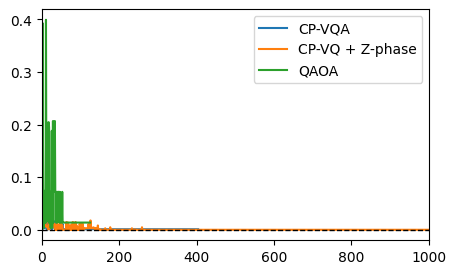

In [27]:
# N.B. Because the normalization is done w. respect to the "allowed states (w. k ones)" QAOA has cost above 1.
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot([it for it in range(len(CP_costs))], CP_costs, label='CP-VQA')
ax.plot([it for it in range(len(CP_z_phase_costs))], CP_z_phase_costs, label='CP-VQ + Z-phase')
ax.plot([it for it in range(len(NORMAL_costs))], NORMAL_costs, label='QAOA')
ax.set_xlim(0,max(len(CP_costs),len(NORMAL_costs), len(CP_z_phase_costs)))
#ax.set_ylim(-0.1,1.1)
ax.hlines(0,0,max(len(CP_costs),len(NORMAL_costs), len(CP_z_phase_costs)),lw=1,linestyles='dashed',colors='k')
ax.legend(loc='upper right')
plt.show()

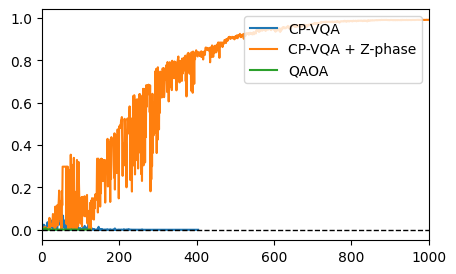

In [26]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot([it for it in range(len(CP_probs))], CP_probs, label='CP-VQA')
ax.plot([it for it in range(len(CP_z_phase_probs))], CP_z_phase_probs, label='CP-VQA + Z-phase')
ax.plot([it for it in range(len(NORMAL_probs))], NORMAL_probs, label='QAOA')
ax.set_xlim(0,max(len(CP_probs),len(NORMAL_probs), len(CP_z_phase_probs)))
#ax.set_ylim(-0.1,1.1)
ax.hlines(0,0,max(len(CP_probs),len(NORMAL_probs), len(CP_z_phase_probs)),lw=1,linestyles='dashed',colors='k')
ax.legend(loc='upper right')
plt.show()

# TRYING OVER MULTIPLE LAYERS (AVG. OVER MULTIPLE SEEDS):

In [29]:
def simulate(datapoint):
    N,k,alpha,max_iter,w_grid,w_nnn,w_strategy,init_strat, seed,N_layers = datapoint

    # Generating grid
    my_grid = Grid(Rows=3, Cols=3)
    my_grid.set_initialization_strategy(strategy=init_strat)

    # Generating random problem instance 
    expected_returns, covariances = portfolio_metrics(n=N, seed=seed)
    
    # Retrieving C_min, C_max and corresponding states.
    constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                                k=k,
                                                                mu=expected_returns,
                                                                sigma=covariances,
                                                                alpha=alpha)
    
    portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
    full_space_max_cost = full_result['c_max']
    portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
    
    # Generating QUBO corresponding to current problem instance
    Q, offset = get_qubo(mu=expected_returns,
                         sigma=covariances,
                         alpha=alpha,
                         lmbda=lmbda,
                         k=k)
    
    QUBO_limits = qubo_limits(Q=Q,offset=offset)
    qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
    qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
    check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
    qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
    
    if not portfolio_subspace_min_state_str == qubo_min_state_str:
        raise RuntimeError(f'portfolio_subspace_min_state_str: {portfolio_subspace_min_state_str}, qubo_min_state_str={qubo_min_state_str}')
    
    if not np.isclose(qubo_min_cost,portfolio_subspace_min_cost):
        raise RuntimeError(f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')
    
    if not qubo_max_cost >= portfolio_subspace_max_cost:
        raise RuntimeError(f'Max. cost of qubo: {qubo_max_cost}, max. cost of portfolio subspace: {portfolio_subspace_max_cost} (should be qubo max. >= constrained portfolio max)')
    
    # Defining method for scipy optimizer
    optimizer_method = 'COBYLA'
    
    # Generating instances of ansatz'
    CP_ansatz = CP_QAOA(N_qubits=N,
                     cardinality=k,
                     layers=N_layers,
                     grid=my_grid if w_grid else None,
                     QUBO_matrix=Q,
                     with_next_nearest_neighbors=w_nnn,
                     with_z_phase=False)
    
    CP_z_phase_ansatz = CP_QAOA(N_qubits=N,
                     cardinality=k,
                     layers=N_layers,
                     grid=my_grid if w_grid else None,
                     QUBO_matrix=Q,
                     with_next_nearest_neighbors=w_nnn,
                     with_z_phase=True)
    
    NORMAL_ansatz = QAOA(N_qubits=N,
                         layers=N_layers,
                         QUBO_matrix=Q,
                         QUBO_offset=offset)
    
    # Generating initial guess for rotation angles for CP_ansatz
    theta_min, theta_max = -2*np.pi, 2*np.pi
    if w_grid:
        N_angles = N_layers * len(my_grid.get_NN_indices())
    else:
        N_angles = N_layers * (N - 1) 
    if w_nnn:
        N_angles += N_layers * (N - 2)
    if w_z_phase:
        N_angles += N_layers * N
    CP_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
    
    
    # Generating callback function for plotting
    CP_costs = [] # Normalized costs
    CP_probs = [] # probability of optimal state
    def CP_callback_function(x):
        _dict_ = CP_ansatz.get_state_probabilities(flip_states=False)
        # N.B. normalizing wrt. max cost of full space
        _cost_ = normalized_cost(result=_dict_,
                                 QUBO_matrix=Q,
                                 QUBO_offset=offset,
                                 max_cost=portfolio_subspace_max_cost, 
                                 min_cost=qubo_min_cost)
        if portfolio_subspace_min_state_str in list(_dict_.keys()):
            CP_probs.append(_dict_[portfolio_subspace_min_state_str])
        else:
            CP_probs.append(0)
        CP_costs.append(_cost_)

    

    # Performing optimization
    CP_res = sc.optimize.minimize(fun=CP_ansatz.get_cost, x0=CP_theta_i,
                               method=optimizer_method,
                               options={'disp': False, 'maxiter': max_iter},
                               callback=CP_callback_function)
    
    
    # Generating callback function for plotting
    CP_z_phase_costs = [] # Normalized costs
    CP_z_phase_probs = [] # probability of optimal state
    def CP_z_phase_callback_function(x):
        _dict_ = CP_z_phase_ansatz.get_state_probabilities(flip_states=False)
        # N.B. Normalizing w. respect to full space max cost
        _cost_ = normalized_cost(result=_dict_,
                                 QUBO_matrix=Q,
                                 QUBO_offset=offset,
                                 max_cost=qubo_max_cost, 
                                 min_cost=qubo_min_cost)
        if portfolio_subspace_min_state_str in list(_dict_.keys()):
            CP_z_phase_probs.append(_dict_[portfolio_subspace_min_state_str])
        else:
            CP_z_phase_probs.append(0)
        CP_z_phase_costs.append(_cost_)
    
    # Generating initial guess for rotation angles for CP_ansatz
    theta_min, theta_max = -2*np.pi, 2*np.pi
    if w_grid:
        N_angles = layers * len(my_grid.get_NN_indices())
    else:
        N_angles = layers * (N - 1) 
    if w_next_nearest_neighbors:
        N_angles += layers * (N - 2)
    N_angles += layers * N # Because this is WITH Z-phase
    CP_z_phase_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
    # Performing optimization
    CP_z_phase_res = sc.optimize.minimize(fun=CP_z_phase_ansatz.get_cost, x0=CP_z_phase_theta_i,
                               method=optimizer_method,
                               options={'disp': False, 'maxiter': max_iter},
                               callback=CP_z_phase_callback_function)
    
    
    # For normal QAOA w. need "layers" nr. of angles for both 'beta' and 'gamma'
    N_angles = 2 * N_layers 
    NORMAL_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
    
    # Generating callback function for plotting
    NORMAL_costs = [] # Normalized costs
    NORMAL_probs = [] # probability of optimal state
    
    def NORMAL_callback_function(x):
        _dict_ = NORMAL_ansatz.get_state_probabilities(flip_states=False)
        # N.B. normalizing wrt. max cost of full space
        _cost_ = normalized_cost(result=_dict_,
                                 QUBO_matrix=Q,
                                 QUBO_offset=offset,
                                 max_cost=portfolio_subspace_max_cost, 
                                 min_cost=qubo_min_cost)
        if portfolio_subspace_min_state_str in list(_dict_.keys()):
            NORMAL_probs.append(_dict_[portfolio_subspace_min_state_str])
        else:
            NORMAL_probs.append(0)
        NORMAL_costs.append(_cost_)
    
    
    NORMAL_res = sc.optimize.minimize(fun=NORMAL_ansatz.get_cost, x0=NORMAL_theta_i,
                               method=optimizer_method,
                               options={'disp': False, 'maxiter': max_iter},
                               callback=NORMAL_callback_function)
    
    return {'(N, k, alpha, max_iter, w_grid, w_nnn, w_strategy, w_z_phase, init_strat, seed, N_layers)': datapoint,
            'CP_VQA': (CP_probs, CP_costs, CP_res),
            'CP_VQA_Z_PHASE': (CP_z_phase_probs, CP_z_phase_costs, CP_z_phase_res),
            'QAOA': (NORMAL_probs, NORMAL_costs, NORMAL_res)}


In [31]:
# Number of Qubits 
N=9
# Number of excitations
k=4
# RNG seed for reproducibility
seed=0
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Maximal number of iterations for classical solver
max_iter=1000

# Using grid Nearest neighbors
w_grid = True
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = False
# Distributing the 'k' excitations according to some strategy (other than just k first)
w_strategy = True
# Using extra z-phase term
w_z_phase = False
# Initialization strategy
init_strat = np.array([[0,1,0],
                       [1,0,1],
                       [0,1,0]])


MAX_N_LAYERS = 3
N_SEEDS = 100
N_jobs = os.cpu_count()-1

datapoints = []
for seed in range(N_SEEDS):
    for layer in range(1,MAX_N_LAYERS+1):
        dp = (N,k,alpha,max_iter,w_grid,w_next_nearest_neighbors,w_strategy,init_strat, seed,layer)
        datapoints.append(dp)
        
r = Parallel(n_jobs=N_jobs, verbose=51, backend='loky')(delayed(simulate)(datapoint) for datapoint in datapoints)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:   18.8s
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:   27.4s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:   31.4s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:   53.6s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:   54.1s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:   55.2s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:   59.8s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:  1.7min
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:  1.7min
[Parallel(n_jobs=7)]: Done  13 tasks      | elapsed:  1.8min
[Parallel(n_jobs=7)]: Done  14 tasks      | elapsed:  1.9min
[Parallel(n_jobs=7)]: Done  15 tasks      | elapsed:  2.1min
[Parallel(

In [32]:
result = {}
for layer in range(1,MAX_N_LAYERS+1):
    result[layer] = {}
    result[layer]['CP_VQA'] = []
    result[layer]['CP_VQA_Z_PHASE'] = []
    result[layer]['QAOA']   = []
    
for run in r:
    layers = run['(N, k, alpha, max_iter, w_grid, w_nnn, w_strategy, w_z_phase, init_strat, seed, N_layers)'][-1]
    CP_props, CP_costs = run['CP_VQA'][0], run['CP_VQA'][1]
    result[layers]['CP_VQA'].append([CP_props[-1], CP_costs[-1]])
    
    CP_z_phase_props, CP_z_phase_costs = run['CP_VQA_Z_PHASE'][0], run['CP_VQA_Z_PHASE'][1]
    result[layers]['CP_VQA_Z_PHASE'].append([CP_z_phase_props[-1], CP_z_phase_costs[-1]])
    
    NORMAL_props, NORMAL_costs = run['QAOA'][0], run['QAOA'][1]
    result[layers]['QAOA'].append([NORMAL_props[-1], NORMAL_costs[-1]])

CP_avgs, CP_std_devs = [], []
CP_z_phase_avgs, CP_z_phase_std_devs = [], []
NORMAL_avgs, NORMAL_std_devs = [], []
for layer in range(1,MAX_N_LAYERS+1):
    CP_avgs.append(np.mean(result[layer]['CP_VQA'], axis=0).tolist())
    CP_std_devs.append(np.std(result[layer]['CP_VQA'], axis=0).tolist())
    
    CP_z_phase_avgs.append(np.mean(result[layer]['CP_VQA_Z_PHASE'], axis=0).tolist())
    CP_z_phase_std_devs.append(np.std(result[layer]['CP_VQA_Z_PHASE'], axis=0).tolist())
    
    NORMAL_avgs.append(np.mean(result[layer]['QAOA'], axis=0).tolist())
    NORMAL_std_devs.append(np.std(result[layer]['QAOA'], axis=0).tolist())
    
CP_avgs, CP_std_devs = np.array(CP_avgs), np.array(CP_std_devs)
CP_z_phase_avgs, CP_z_phase_std_devs = np.array(CP_z_phase_avgs), np.array(CP_z_phase_std_devs)
NORMAL_avgs, NORMAL_std_devs = np.array(NORMAL_avgs), np.array(NORMAL_std_devs)

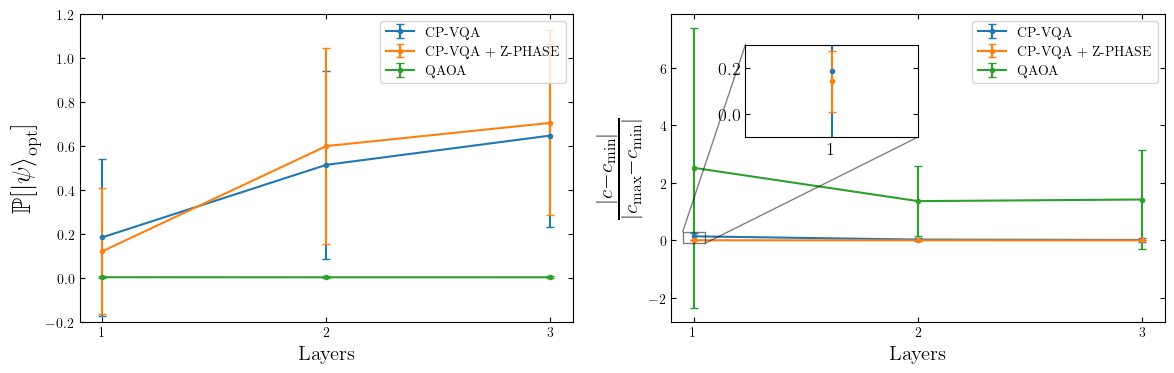

In [59]:
plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{physics}'
plt.rc("xtick", top=True, direction="in")
plt.rc("ytick", right=True, direction="in")

fig, ax = plt.subplots(1,2,figsize=(14,4))
layers = [layer for layer in range(1,MAX_N_LAYERS+1)]
ax[0].errorbar(layers, CP_avgs[:,0],yerr=CP_std_devs[:,0], fmt='.-', capsize=3, label='CP-VQA')
ax[0].errorbar(layers, CP_z_phase_avgs[:,0],yerr=CP_z_phase_std_devs[:,0], fmt='.-', capsize=3, label='CP-VQA + Z-PHASE')
ax[0].errorbar(layers, NORMAL_avgs[:,0],yerr=NORMAL_std_devs[:,0], fmt='.-', capsize=3, label='QAOA')
ax[0].set_xticks(layers)
ax[0].set_ylabel(r'$\mathbb{P}[\ket{\psi}_{\text{opt}}]$',size=19)
ax[0].set_ylim(-0.2,1.2)
ax[0].legend(loc='upper right')
ax[0].set_xlabel('Layers',size=15)

ax[1].errorbar(layers, CP_avgs[:,1],yerr=CP_std_devs[:,1], fmt='.-', capsize=3, label='CP-VQA')
ax[1].errorbar(layers, CP_z_phase_avgs[:,1],yerr=CP_z_phase_std_devs[:,1],fmt='.-', capsize=3, label='CP-VQA + Z-PHASE')
ax[1].errorbar(layers, NORMAL_avgs[:,1],yerr=NORMAL_std_devs[:,1], fmt='.-',capsize=3, label='QAOA')
ax[1].set_xticks(layers)
#ax[1].set_ylim(-0.2,1.2)
ax[1].legend(loc='upper right')
ax[1].set_ylabel(r'$\frac{|c-c_{\textrm{min}}|}{|c_{\textrm{max}}-c_{\textrm{min}}|}$', size=22)
ax[1].set_xlabel('Layers',size=15)

################## miniplot ##################
# inset axes....
axins_x_left, axins_y_lower, axins_x_width, axins_height = 0.15, 0.6, 0.35, 0.3
axins = ax[1].inset_axes([axins_x_left, axins_y_lower, axins_x_width, axins_height])
axins.errorbar(layers[0], CP_avgs[:,0][0],yerr=CP_std_devs[:,0][0], fmt='.-', capsize=3)
axins.errorbar(layers[0], CP_avgs[:,1][0],yerr=CP_std_devs[:,1][0], fmt='.-', capsize=3)
# sub region of the original image
x1, x2, y1, y2 = 0.95, 1.05, -0.1, 0.3
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([1])
axins.tick_params(axis='both', which='major', labelsize=13)
ax[1].indicate_inset_zoom(axins, edgecolor="black")


plt.savefig('../figures/fig_1.png',dpi=300)
plt.show()